# Nonlinearities

In [1]:
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_circles #, make_moons

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


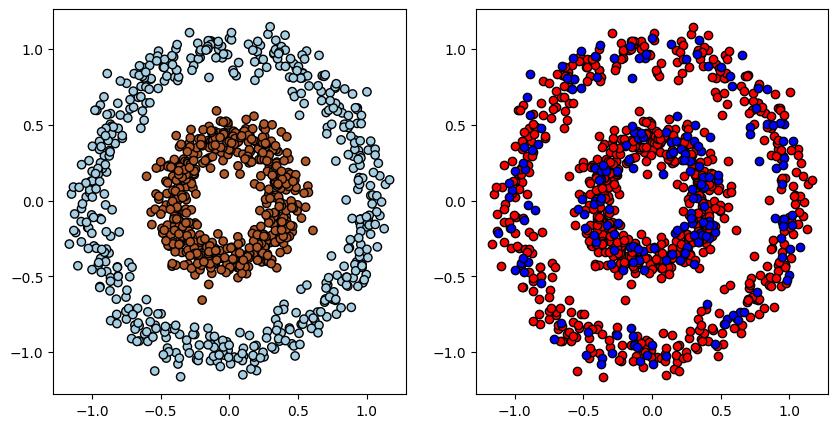

In [2]:
# Configuration options
num_classes = 2
X, y = make_circles(n_samples= 1000 , noise=0.08, factor=0.4)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(10,5))

axes[0].scatter( X[:, 0] , X[:, 1] , c = y , cmap='Paired', edgecolors='k')
axes[1].scatter( X_train[:, 0] , X_train[:, 1] , c="r", edgecolors='k')
axes[1].scatter( X_test[:, 0] , X_test[:, 1] , c="b", edgecolors='k')

In [3]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [4]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [5]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


## Create a graph model

In [24]:
model = nn.Sequential(
    nn.Linear(2, 20), nn.ReLU(),
    nn.Linear(20, 2), #nn.Sigmoid() nn.Softmax()
)

# model.cuda()
summary(model, input_size=(2,))
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
              ReLU-2                   [-1, 20]               0
            Linear-3                    [-1, 2]              42
Total params: 102
Trainable params: 102
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Define loss function and optimizer

In [25]:
loss = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #torch.optim.Adam(model.parameters(), lr = 1e-3)

# model.cuda()
# loss.cuda()

## Train model

In [26]:
epochs = 800
batch_size = 200
losses = []

progress = tqdm(range( epochs ), ncols=110)

for epoch in progress:
  #
  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32)#.cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32)#.cuda()

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model( batch_X )

    # Compute loss
    batch_loss = loss( predictions , batch_y )

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()

  epoch_loss = batch_losses/(len(X_train)/batch_size)

  progress.set_description("Epoch [%d/%d] [Loss: %f] " % (epoch, epochs,
                                                                   epoch_loss))

  losses.append(epoch_loss)


Epoch [799/800] [Loss: 0.649291] : 100%|███████████████████████████████████| 800/800 [00:06<00:00, 116.62it/s]


## Plot results

Text(0.5, 0, 'Epoch')

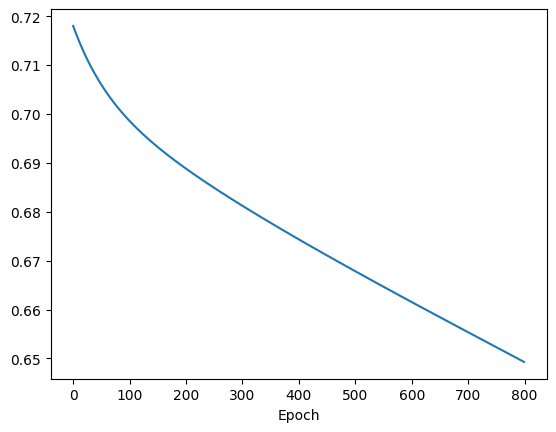

In [27]:
import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")

In [28]:
h_min, h_max = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
v_min, v_max = X_test[:, 1].min()-0.1, X_test[:, 1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 200), np.linspace( v_min , v_max , 200))

# Predecir los valores del grid
grid_ = np.c_[h_grid.ravel(), v_grid.ravel()]
grid_ = torch.from_numpy( grid_ ).to(torch.float32)#.cuda()
predictions = model( grid_ )
predictions = np.argmax( predictions.detach().cpu().numpy() , axis=1)
print (predictions.shape)

# Encajar las predicciones al tamaño del grid
predictions = predictions.reshape(h_grid.shape)
print (predictions.shape)

(40000,)
(200, 200)


[]

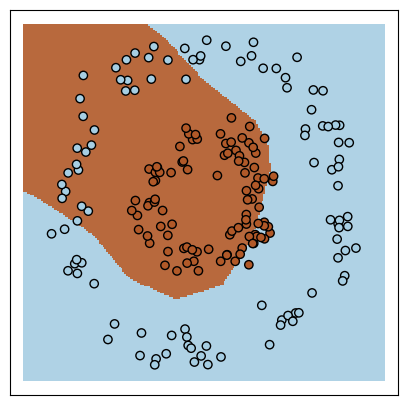

In [29]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
plt.pcolormesh( h_grid , v_grid , predictions , cmap=plt.cm.Paired, alpha=0.9)

ax.scatter( X_test[:, 0] , X_test[:, 1] , c = np.argmax(y_test, axis=1) , edgecolors='k', cmap=plt.cm.Paired)

ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())